# The link of the Dataset is the project final document(Dataset Section)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
#from keras.applications.ResNet50 import ResNet50
#from keras.applications import InceptionResNetV2
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/train/'

/content/gdrive/My Drive/train


In [ ]:
training_images = tf.io.gfile.glob('/content/gdrive/My Drive/train/*/*')
total_files = training_images
train_images, val_images = train_test_split(total_files, test_size = 0.1,random_state=42)
print(len(train_images))
print(len(val_images))

4694
522


Normal images count in training set: 1191
Pneumonia images count in training set: 3503


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


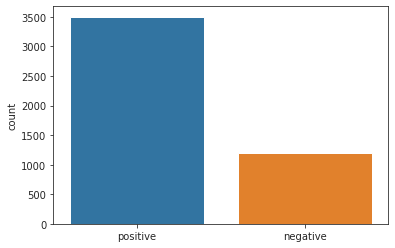

In [ ]:
count_normal = len([x for x in train_images if "NORMAL" in x])
print(f'Normal images count in training set: {count_normal}')

count_pneumonia = len([x for x in train_images if "PNEUMONIA" in x])
print(f'Pneumonia images count in training set: {count_pneumonia}')

count_array = []
count_array += ['positive']*count_pneumonia
count_array += ['negative']*count_normal

sns.set_style('ticks')
sns.countplot(count_array)

In [ ]:
tf.io.gfile.makedirs('/content/gdrive/My Drive/val_dataset/negative/')
tf.io.gfile.makedirs('/content/gdrive/My Drive/val_dataset/positive/')
tf.io.gfile.makedirs('/content/gdrive/My Drive/train_dataset/negative/')
tf.io.gfile.makedirs('/content/gdrive/My Drive/train_dataset/positive/')


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                 rotation_range = 30,
                                 zoom_range = 0.2,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1)
val_datagen = ImageDataGenerator(rescale = 1/255)
                                

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/train_dataset/',
    target_size = [300,300],
    class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/val_dataset/',
    target_size = [300,300],
    class_mode = 'binary')

Found 4172 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.


In [ ]:
eval_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = eval_datagen.flow_from_directory(
    '/content/gdrive/My Drive/test',
    target_size =[300,300],
    class_mode = 'binary')

Found 859 images belonging to 2 classes.


In [ ]:
weight_for_0 = (1 / count_normal)*(len(train_images))/2.0 
weight_for_1 = (1 / count_pneumonia)*(len(train_images))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


In [ ]:
vgg=VGG16(input_shape=[300,300]+[3],weights='imagenet',include_top=False)
for layer in vgg.layers:
    layer.trainable=False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# INCEPTIONResNetV2
inception=InceptionResNetV2(input_shape=[150,150]+[3],weights='imagenet',include_top=False)
for layer in inception.layers:
    layer.trainable=False

NameError: ignored

In [ ]:
model=Sequential([vgg,
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(256, activation=tf.nn.relu),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(256, activation=tf.nn.relu),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)])
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 256)               10617088  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint("model1_vgg.h5",save_best_only=True)

early_stopping_cb1 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=20, mode = 'min',restore_best_weights=True)
history1 = model.fit(
    train_generator,
    steps_per_epoch = 64,
    epochs = 25,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [early_stopping_cb1,checkpoint_cb1])

Epoch 1/25
64/64 [==============================] - 873s 13s/step - loss: 1.4407 - accuracy: 0.6928 - precision: 0.8668 - recall: 0.6756 - val_loss: 0.6439 - val_accuracy: 0.6590 - val_precision: 0.9978 - val_recall: 0.5568
Epoch 2/25
64/64 [==============================] - 303s 5s/step - loss: 0.3721 - accuracy: 0.8501 - precision: 0.9531 - recall: 0.8389 - val_loss: 0.3770 - val_accuracy: 0.8132 - val_precision: 0.9967 - val_recall: 0.7591
Epoch 3/25
64/64 [==============================] - 187s 3s/step - loss: 0.3139 - accuracy: 0.8809 - precision: 0.9664 - recall: 0.8667 - val_loss: 1.4782 - val_accuracy: 0.5517 - val_precision: 1.0000 - val_recall: 0.4157
Epoch 4/25
64/64 [==============================] - 123s 2s/step - loss: 0.2920 - accuracy: 0.8896 - precision: 0.9686 - recall: 0.8787 - val_loss: 0.3141 - val_accuracy: 0.8554 - val_precision: 0.9939 - val_recall: 0.8165
Epoch 5/25
64/64 [==============================] - 91s 1s/step - loss: 0.2641 - accuracy: 0.8994 - precisi

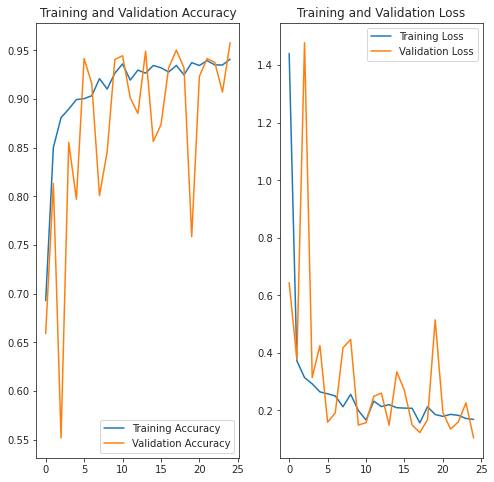

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
eval_result1=model.evaluate_generator(test_generator)
print('loss rate on evaluation data :', eval_result1[0])
print('accuracy rate on evaluation data :', eval_result1[1])
print('precision on evaluation data :', eval_result1[2])
print('Recall on evaluation data :', eval_result1[3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


loss rate on evaluation data : 0.23110218346118927
accuracy rate on evaluation data : 0.9266589283943176
precision on evaluation data : 0.9169139266014099
Recall on evaluation data : 0.9887999892234802


In [ ]:
class_vgg=model.predict(test_generator)


In [ ]:
for i in range (class_vgg.shape[0]):
  if class_vgg[i]<=0.5:
    class_vgg[i]==0
  else:
    class_vgg[i]==1

In [ ]:
print(confusion_matrix(test_generator.classes, class_vgg))
pd.DataFrame(classification_report(test_generator.classes, class_vgg, output_dict=True))

ValueError: ignored

#Model of InceptionResnetV2


In [ ]:
# Model for InceptionResnetV2
model_inception=Sequential([inception,
                tf.keras.layers.Flatten(), 
                tf.keras.layers.Dense(512,activation=tf.nn.relu),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(512,activation=tf.nn.relu),
                tf.keras.layers.Dropout(0.7),
                tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)])
model_inception.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               7078400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint("model1_inception.h5",
                                                    save_best_only=True)
early_stopping_cb1 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=10, mode = 'min',restore_best_weights=True)
history3 = model_inception.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 20,
    validation_data = validation_generator,
    class_weight=class_weight)
 

Epoch 1/20
10/10 [==============================] - 46s 2s/step - loss: 7.6033 - accuracy: 0.5769 - precision: 0.7552 - recall: 0.5726 - val_loss: 38368.8203 - val_accuracy: 0.2826 - val_precision: 0.9815 - val_recall: 0.0662
Epoch 2/20
10/10 [==============================] - 15s 2s/step - loss: 1.9413 - accuracy: 0.7379 - precision: 0.8477 - recall: 0.8171 - val_loss: 553.0750 - val_accuracy: 0.7759 - val_precision: 0.9522 - val_recall: 0.7453
Epoch 3/20
10/10 [==============================] - 16s 2s/step - loss: 0.3023 - accuracy: 0.8806 - precision: 0.9674 - recall: 0.8677 - val_loss: 110.5588 - val_accuracy: 0.8611 - val_precision: 0.9726 - val_recall: 0.8427
Epoch 4/20
10/10 [==============================] - 16s 2s/step - loss: 3.1057 - accuracy: 0.8721 - precision: 0.9413 - recall: 0.8602 - val_loss: 750.5892 - val_accuracy: 0.4425 - val_precision: 0.9740 - val_recall: 0.2809
Epoch 5/20
10/10 [==============================] - 16s 2s/step - loss: 0.6694 - accuracy: 0.8714 - pr

In [ ]:
eval_result1=model_inception.evaluate(test_generator)
print('loss rate on evaluation data :', eval_result1[0])
print('accuracy rate on evaluation data :', eval_result1[1])
print('Precision on evaluation data :', eval_result1[2])
print('Recall on evaluation data :', eval_result1[3])

27/27 [==============================] - 7s 272ms/step - loss: 65.5445 - accuracy: 0.9336 - precision: 0.9343 - recall: 0.9776
loss rate on evaluation data : 65.54446411132812
accuracy rate on evaluation data : 0.9336437582969666
Precision on evaluation data : 0.9342507719993591
Recall on evaluation data : 0.9775999784469604


In [ ]:
class_inception=model_inception.predict_classes(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(confusion_matrix(test_generator.classes,class_inception))
pd.DataFrame(classification_report(test_generator.classes,class_inception, output_dict=True))

[[ 55 179]
 [150 475]]


,0,1,accuracy,macro avg,weighted avg
precision,0.268293,0.726300,0.616997,0.497296,0.601534
recall,0.235043,0.760000,0.616997,0.497521,0.616997
f1-score,0.250569,0.742768,0.616997,0.496669,0.608688
support,234.000000,625.000000,0.616997,859.000000,859.000000


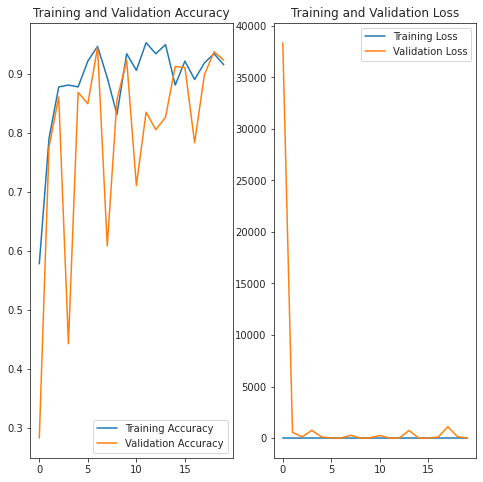

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Model of INCEPTION V3

In [ ]:
# Inception v3 model
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False,input_shape=(150, 150,3) )

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale = 1/255)
                                

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/train_dataset/',
    target_size = [150,150],
    class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/val_dataset/',
    target_size = [150,150],
    class_mode = 'binary')
eval_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = eval_datagen.flow_from_directory(
    '/content/gdrive/My Drive/test',
    target_size =[150,150],
    class_mode = 'binary')

Found 4172 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 859 images belonging to 2 classes.


In [ ]:
# Model for inception v2
model_v2=Sequential([base_model,
                tf.keras.layers.Dropout(0.5),                    
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(1, activation='sigmoid')])
model_v2.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model_v2.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
batch_normalization_297 (Bat (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 22,065,697
Trainable params: 22,031,009
Non-trainable params: 34,688
_____________________________________

In [ ]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint= tf.keras.callbacks.ModelCheckpoint("model_v2.h5",
                                                    save_best_only=True)

In [ ]:
history = model_v2.fit(train_generator, validation_data = validation_generator ,callbacks=[lr_reduce,checkpoint] ,
          epochs=15)

Epoch 1/15
131/131 [==============================] - 857s 6s/step - loss: 0.4642 - accuracy: 0.8095 - precision: 0.9081 - recall: 0.8181 - val_loss: 0.8047 - val_accuracy: 0.7672 - val_precision: 0.7672 - val_recall: 1.0000
Epoch 2/15
131/131 [==============================] - 80s 614ms/step - loss: 0.2412 - accuracy: 0.9137 - precision: 0.9421 - recall: 0.9410 - val_loss: 1.2243 - val_accuracy: 0.7672 - val_precision: 0.7672 - val_recall: 1.0000

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/15
131/131 [==============================] - 79s 605ms/step - loss: 0.2093 - accuracy: 0.9239 - precision: 0.9620 - recall: 0.9356 - val_loss: 1.0507 - val_accuracy: 0.7672 - val_precision: 0.7672 - val_recall: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/15
131/131 [==============================] - 79s 602ms/step - loss: 0.1738 - accuracy: 0.9348 - precision: 0.9531 - recall: 0.9576 - val_loss: 0.224

In [ ]:
eval_result1=model_v2.evaluate_generator(test_generator)
print('loss rate on evaluation data :', eval_result1[0])
print('accuracy rate on evaluation data :', eval_result1[1])
print('precision on evaluation data :', eval_result1[2])
print('recall on evaluation data :', eval_result1[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss rate on evaluation data : 0.2706884443759918
accuracy rate on evaluation data : 0.9138533473014832
precision on evaluation data : 0.9105812311172485
recall on evaluation data : 0.9138533473014832


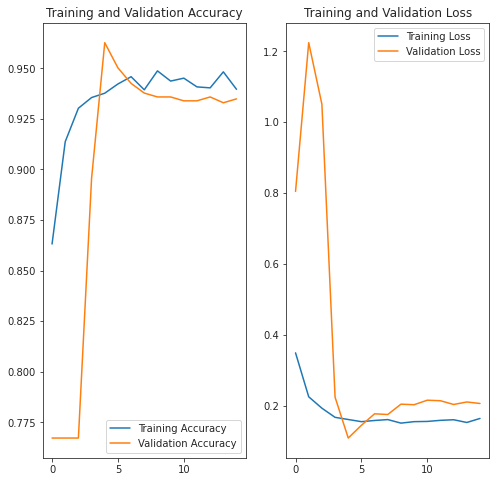

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_v2=model_v2.predict_classes(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(confusion_matrix(test_generator.classes,class_v2))

[[ 51 183]
 [137 488]]


#Ensemble by majority 

In [ ]:
|# Ensemble of VGG16, inceptionresentv2 and  inceptionv3
class_Ensemble=[]
for i in range(len(class_v2)):
  l=[]
  l.append(class_v2[i][0])
  l.append(class_inception[i][0])
  l.append(class_vgg[i][0])
  class_Ensemble.append(l)

In [ ]:
final=[]
for i in range (len(class_Ensemble)):
  output=[]
  class_Ensemble[i].sort()
  output.append(class_Ensemble[i][1])
  final.append(output)


In [ ]:
print(confusion_matrix(test_generator.classes,final))
pd.DataFrame(classification_report(test_generator.classes,final, output_dict=True))

[[ 16 218]
 [ 48 577]]


,0,1,accuracy,macro avg,weighted avg
precision,0.250000,0.725786,0.690338,0.487893,0.596177
recall,0.068376,0.923200,0.690338,0.495788,0.690338
f1-score,0.107383,0.812676,0.690338,0.460029,0.620547
support,234.000000,625.000000,0.690338,859.000000,859.000000
